In [1]:
import rebound
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import fastparquet

In [2]:
def pair_generator(N):
    data = np.random.rand(N, 2) * np.array([-0.5, 1])
    id = np.where((np.linalg.norm(data, axis=1) >= 1) + (np.linalg.norm(np.array([-1, 0]) - data, axis=1) >= 1))[0]
    while len(id) > 0:
        data[id] = np.random.rand(len(id), 2) * np.array([-0.5, 1])
        id = np.where((np.linalg.norm(data, axis=1) >= 1) + (np.linalg.norm(np.array([-1, 0]) - data, axis=1) >= 1))[0]
    return data

In [3]:
def collision_res(sim_pointer, collision):
    return 3 # Removes the collided particles

In [4]:
NS = 10000 # Number of Simulations
Data = pair_generator(NS)
S = []
for ii in range(NS):
  sim = rebound.Simulation()
  sim.integrator = "IAS15"
  sim.collision = 'direct'
  sim.collision_resolve = collision_res
  sim.ri_ias15.epsilon = 1e-10
  
  S.append(sim)
  del(sim)

for i, Sim in enumerate(S):
  # Particle 1
  p = rebound.Particle()
  p.m = 1
  p.x, p.y = 1, 0
  p.r = 1e-5
  Sim.add(p)

  # Particle 2
  p = rebound.Particle()
  p.m = 1
  p.x, p.y = Data[i]
  p.r = 1e-5
  Sim.add(p)

  # Particle 3
  p = rebound.Particle()
  p.m = 1
  p.x, p.y = -1-Data[i, 0], -Data[i, 1]
  p.r = 1e-5
  Sim.add(p)

In [5]:
T = 10
N = 2560
time_ = np.linspace(0, T, N+1)
phasespace = np.zeros((NS, N+1, 3, 4))
collision_check = np.zeros(NS)

In [6]:
t_ = time.time()
for ii in range(NS):
    s = 0
    for i,t in enumerate(time_):
        S[ii].integrate(t,exact_finish_time=1)
        if S[ii].N < 3:
            collision_check[ii] = 1
            break
        for j in range(3):
            phasespace[ii, i, j, 0] = S[ii].particles[j].x
            phasespace[ii, i, j, 1] = S[ii].particles[j].y
            phasespace[ii, i, j, 2] = S[ii].particles[j].vx
            phasespace[ii, i, j, 3] = S[ii].particles[j].vy
    print("Simulation #{0} / {1}, Num Collisions = {2}".format(ii+1, NS, int(collision_check.sum())), end='\r', flush=True)

t_ = time.time() - t_

/home/aebrazeh/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


In [7]:
def Energy(data):
    R, V = np.split(data, 2, axis=-1)
    KineticEnergy = (V**2 / 2).sum(axis=-1).sum(axis=-1)

    PotentialEnergy = np.zeros_like(KineticEnergy)
    for ii in range(3):
        for jj in range(ii):
            PotentialEnergy -= 1 / np.linalg.norm(R[:, :, jj] - R[:, :, ii], axis=-1)

    Energy = KineticEnergy + PotentialEnergy
    return Energy

In [8]:
def Range(x, axis=-1):
    return x.max(axis) - x.min(axis)

In [17]:
phasespace_ = phasespace[np.where(collision_check == 0)] # Removes failed simulations
phasespace_ = phasespace_[np.where(Range(Energy(phasespace_)) < 1e-10)[0]] # Energy Error Treshold

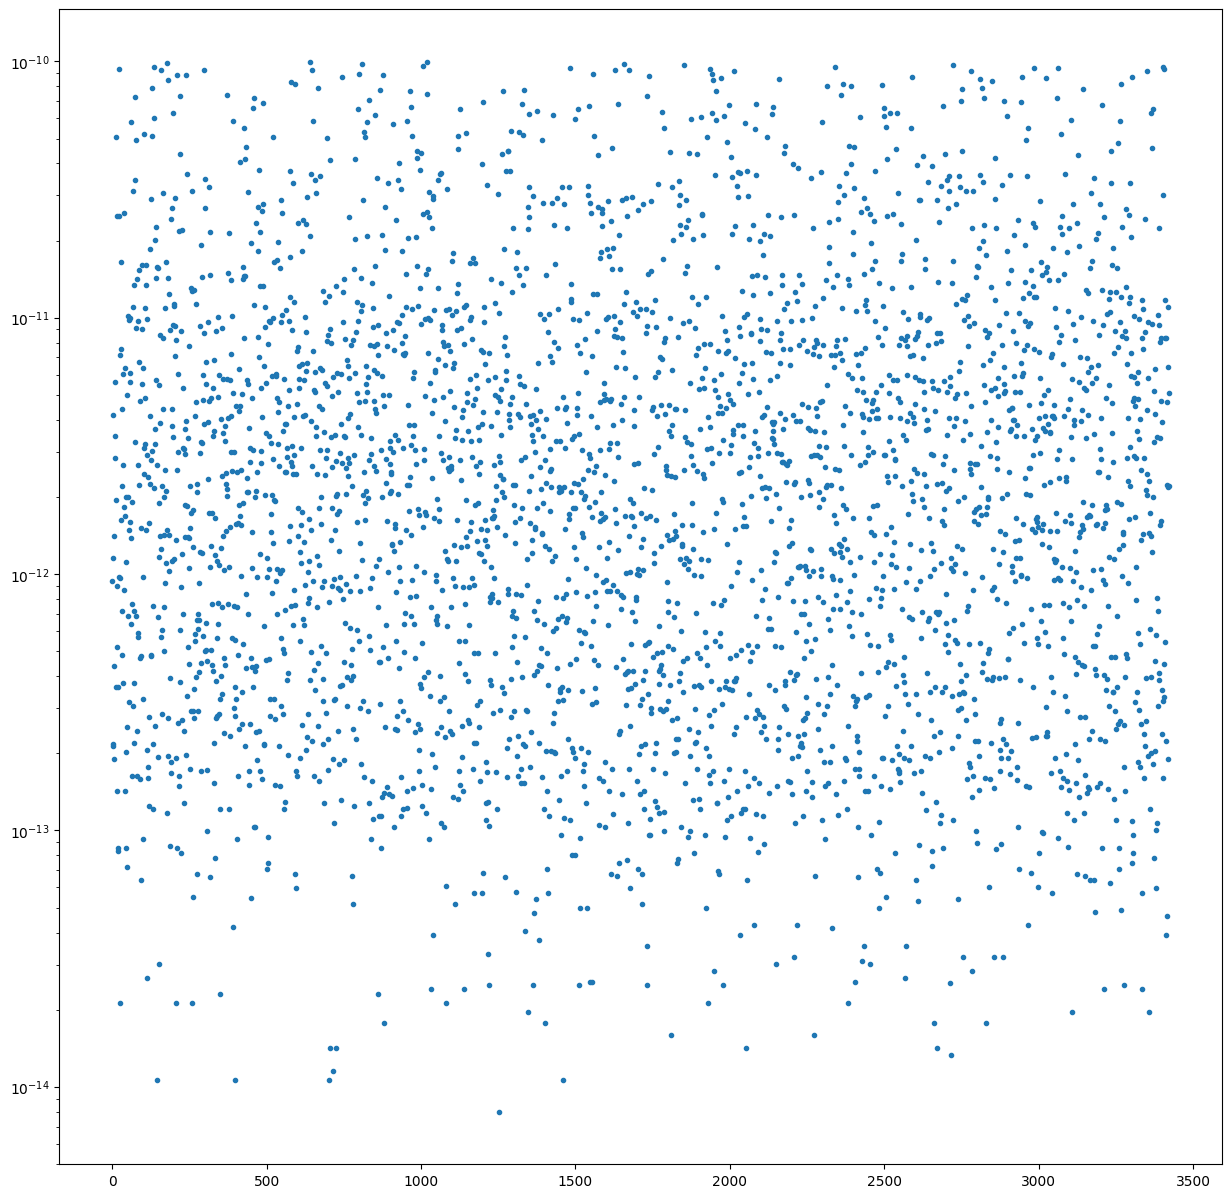

In [18]:
plt.figure(figsize=(15, 15))
plt.yscale('log')
plt.plot(Range(Energy(phasespace_)), '.')
plt.show()

In [20]:
c = ["x1", "y1", "dx1", "dy1", "x2", "y2", "dx2", "dy2", "x3", "y3", "dx3", "dy3"]

In [21]:
pd.DataFrame(phasespace_.reshape(-1, 12), columns=c).to_parquet('Data.parquet')